# SubgraphX on BA-Shapes dataset for 2-layer GCN

In [5]:
import os
import os.path as osp

import torch
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [6]:
dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

### Load model and checkpoints

In [7]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)


model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['state_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
from dig.xgraph.method import SubgraphX

explainer = SubgraphX(model, num_classes=4, device=device,
                      explain_graph=False, reward_method='nc_mc_l_shapley')

### Visualization

[302, 313, 321, 332, 336, 348, 356, 367, 369, 381, 387, 418, 454, 461, 466, 469, 471, 497, 508, 514, 515, 532, 542, 548, 561, 564, 569, 586, 588, 595, 616, 621, 648, 655, 663, 665, 673, 690, 691, 694, 696, 699]
explain graph node 515


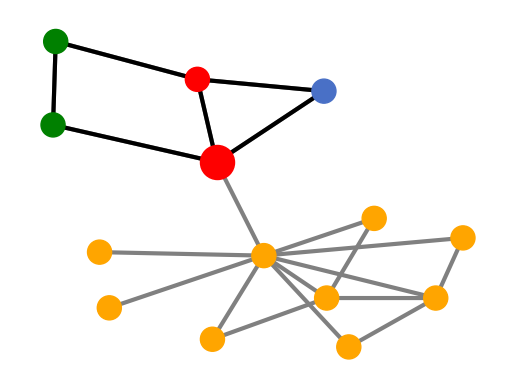

In [6]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
print(node_indices)
data = dataset[0]

from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result

# Visualization
max_nodes = 5
node_idx = node_indices[20]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
explainer.visualization(explanation_results,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

explain graph node 515

Best Subgraph:
  Nodes: [9, 10, 11, 12, 13]
  Edges: [(9, 10), (9, 12), (9, 13), (10, 9), (10, 11), (10, 13), (11, 10), (11, 12), (12, 9), (12, 11), (13, 9), (13, 10)]
  Score: 2.5075972080230713
  P: 0.6268993020057678
  N: 4


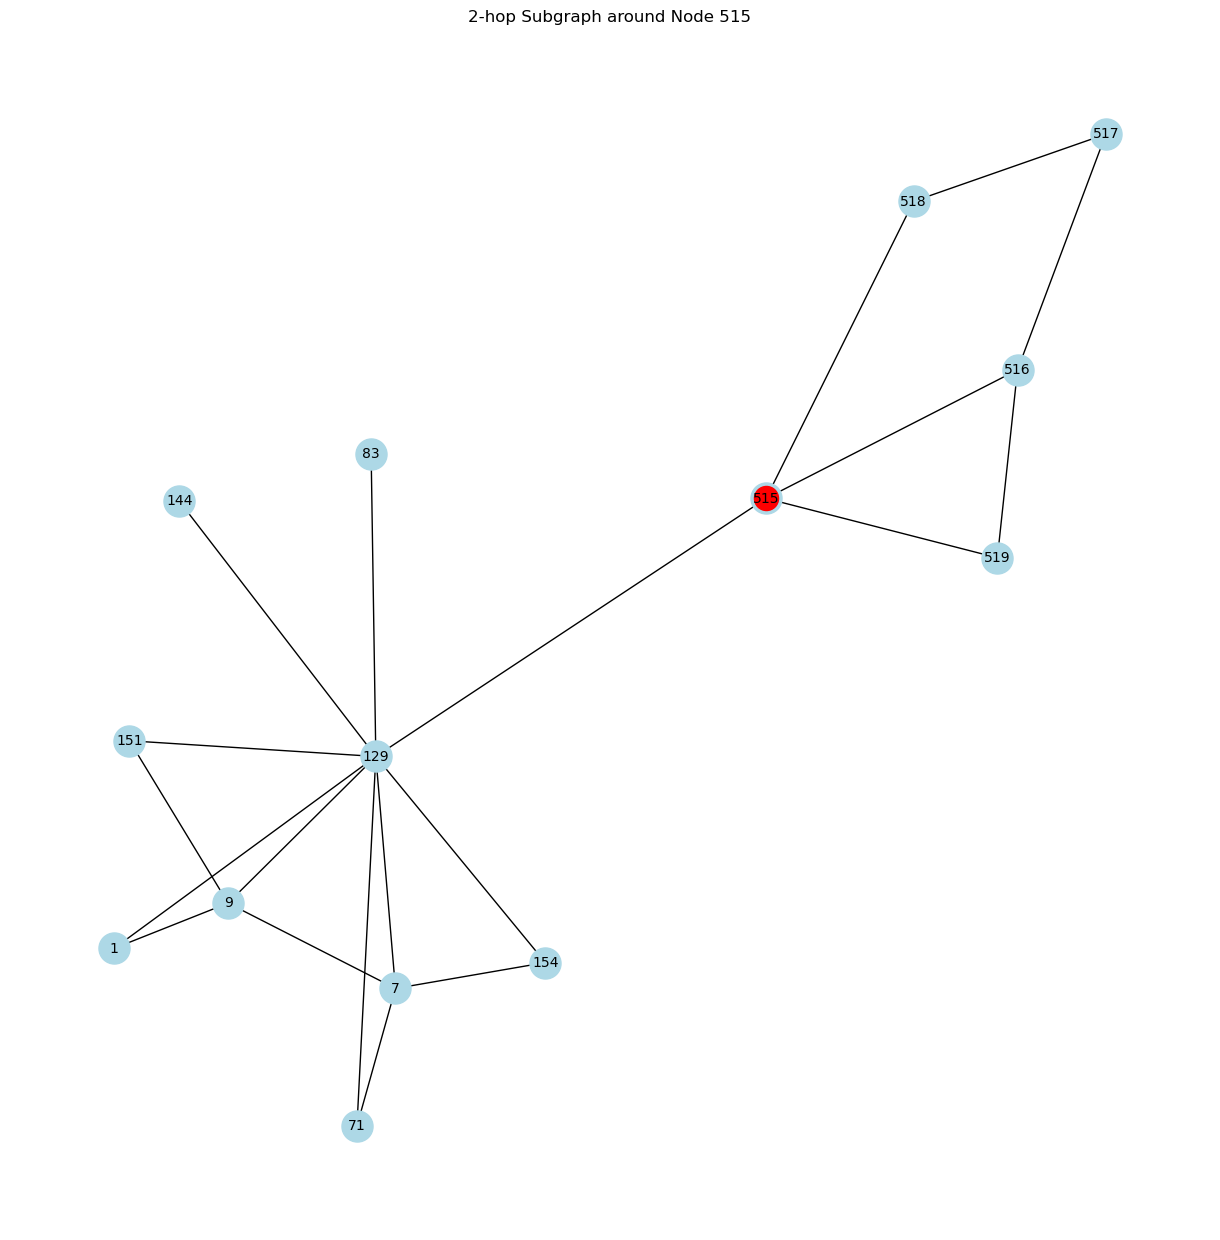

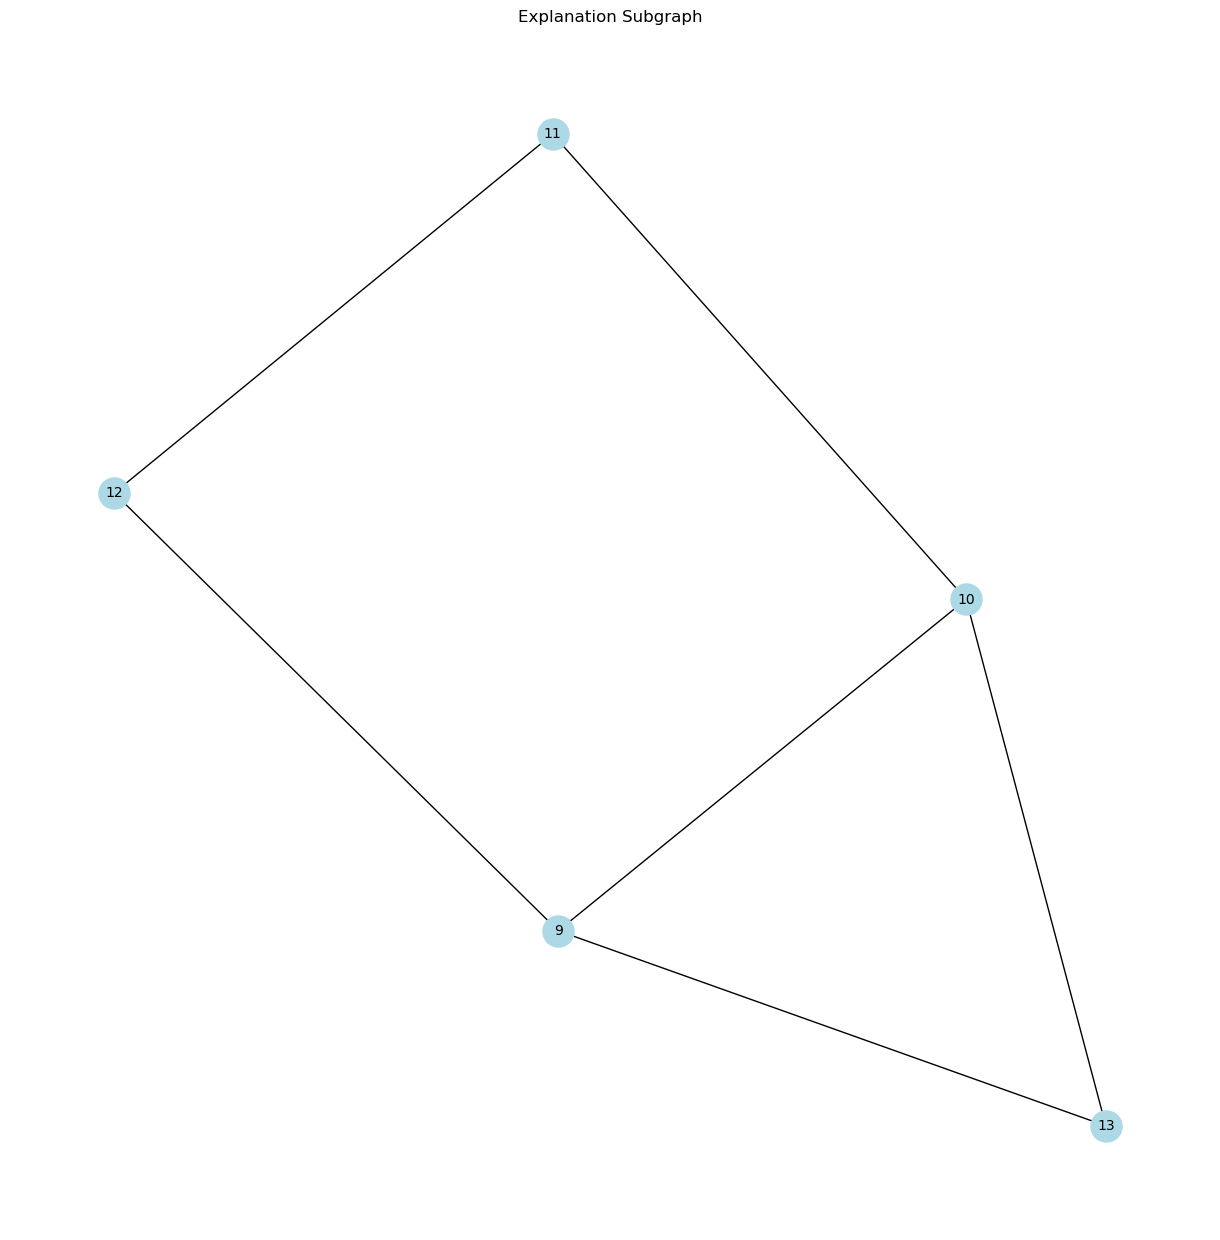

In [12]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
import torch
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `dataset` is defined elsewhere in your code
# dataset = ... (Load or define your dataset here)

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

# Visualization
max_nodes = 5
node_idx = node_indices[20]
highlight_node = 515
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

# Obtain the explanation results
_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

# Step 1: Extract Subgraph Information from explanation_results
def extract_subgraph_info(explanation_results):
    nodes = set()
    edges = set()
    detailed_info = []
    for mcts_node in explanation_results:
        coalition_nodes = mcts_node.coalition
        if coalition_nodes is not None:
            nodes.update(coalition_nodes)
            mcts_edges = mcts_node.data.edge_index.t().tolist()
            for edge in mcts_edges:
                if edge[0] in coalition_nodes and edge[1] in coalition_nodes:
                    edges.add((edge[0], edge[1]))
            detailed_info.append({
                "nodes": coalition_nodes,
                "edges": [(edge[0], edge[1]) for edge in mcts_edges if edge[0] in coalition_nodes and edge[1] in coalition_nodes],
                "score": mcts_node.info.get("W", None),
                "P": mcts_node.P,
                "N": mcts_node.N
            })
        else:
            print("Coalition not found in MCTSNode")
    return nodes, edges, detailed_info

# Extract nodes, edges, and detailed info from explanation_results
nodes, edges, detailed_info = extract_subgraph_info(explanation_results)

# Find the subgraph with the highest score
best_subgraph = max(detailed_info, key=lambda x: x["score"])

# Print the best subgraph information
print("\nBest Subgraph:")
print(f"  Nodes: {best_subgraph['nodes']}")
print(f"  Edges: {best_subgraph['edges']}")
print(f"  Score: {best_subgraph['score']}")
print(f"  P: {best_subgraph['P']}")
print(f"  N: {best_subgraph['N']}")

# Function to visualize 2-hop subgraph
def visualize_2hop_subgraph(data, highlight_node):
    G = nx.Graph()
    overall_edges = data.edge_index.t().tolist()
    G.add_edges_from(overall_edges)
    
    # Extract 2-hop subgraph
    two_hop_subgraph = nx.ego_graph(G, highlight_node, radius=2)
    
    pos = nx.spring_layout(two_hop_subgraph)
    plt.figure(figsize=(12, 12))
    
    # Draw 2-hop subgraph
    nx.draw(two_hop_subgraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
    nx.draw_networkx_nodes(two_hop_subgraph, pos, nodelist=[highlight_node], node_color='red')
    
    plt.title("2-hop Subgraph around Node 515")
    plt.show()

# Function to visualize explanation subgraph
def visualize_explanation_subgraph(best_subgraph):
    G = nx.Graph()
    G.add_nodes_from(best_subgraph['nodes'])
    G.add_edges_from(best_subgraph['edges'])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    
    # Draw explanation subgraph
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
    
    plt.title("Explanation Subgraph")
    plt.show()

# Visualize the 2-hop subgraph
visualize_2hop_subgraph(data, highlight_node)

# Visualize the explanation subgraph
visualize_explanation_subgraph(best_subgraph)

explain graph node 515

Best Subgraph:
  Nodes: [9, 10, 11, 12, 13]
  Edges: [(9, 10), (9, 12), (9, 13), (10, 9), (10, 11), (10, 13), (11, 10), (11, 12), (12, 9), (12, 11), (13, 9), (13, 10)]
  Score: 2.640998363494873
  P: 0.6602495908737183
  N: 4


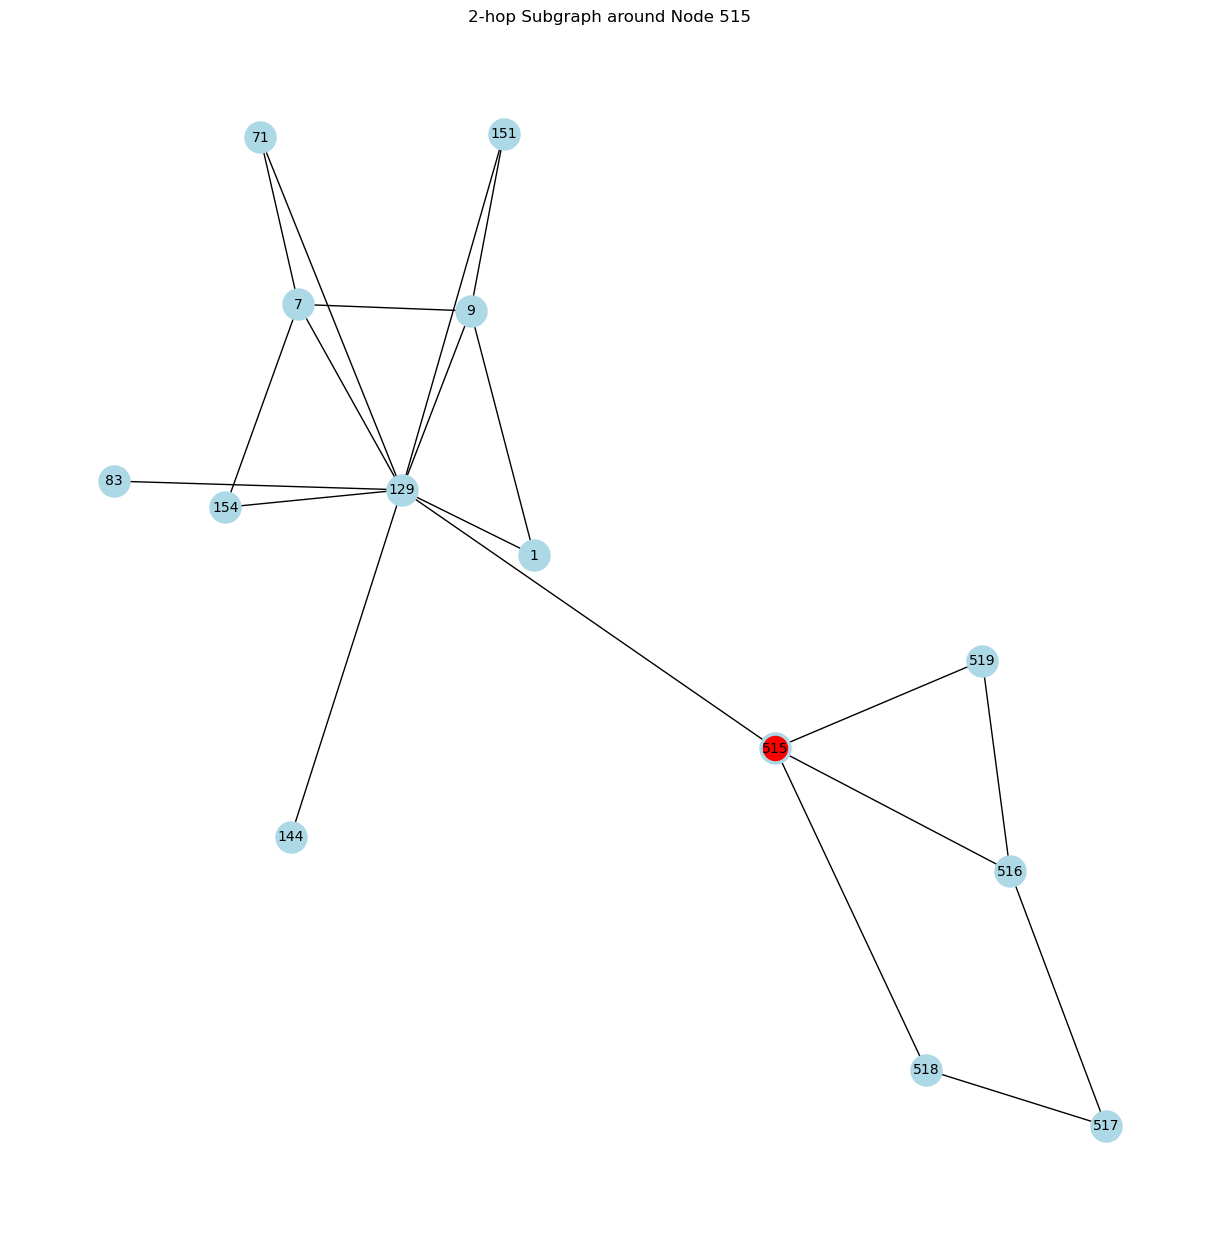

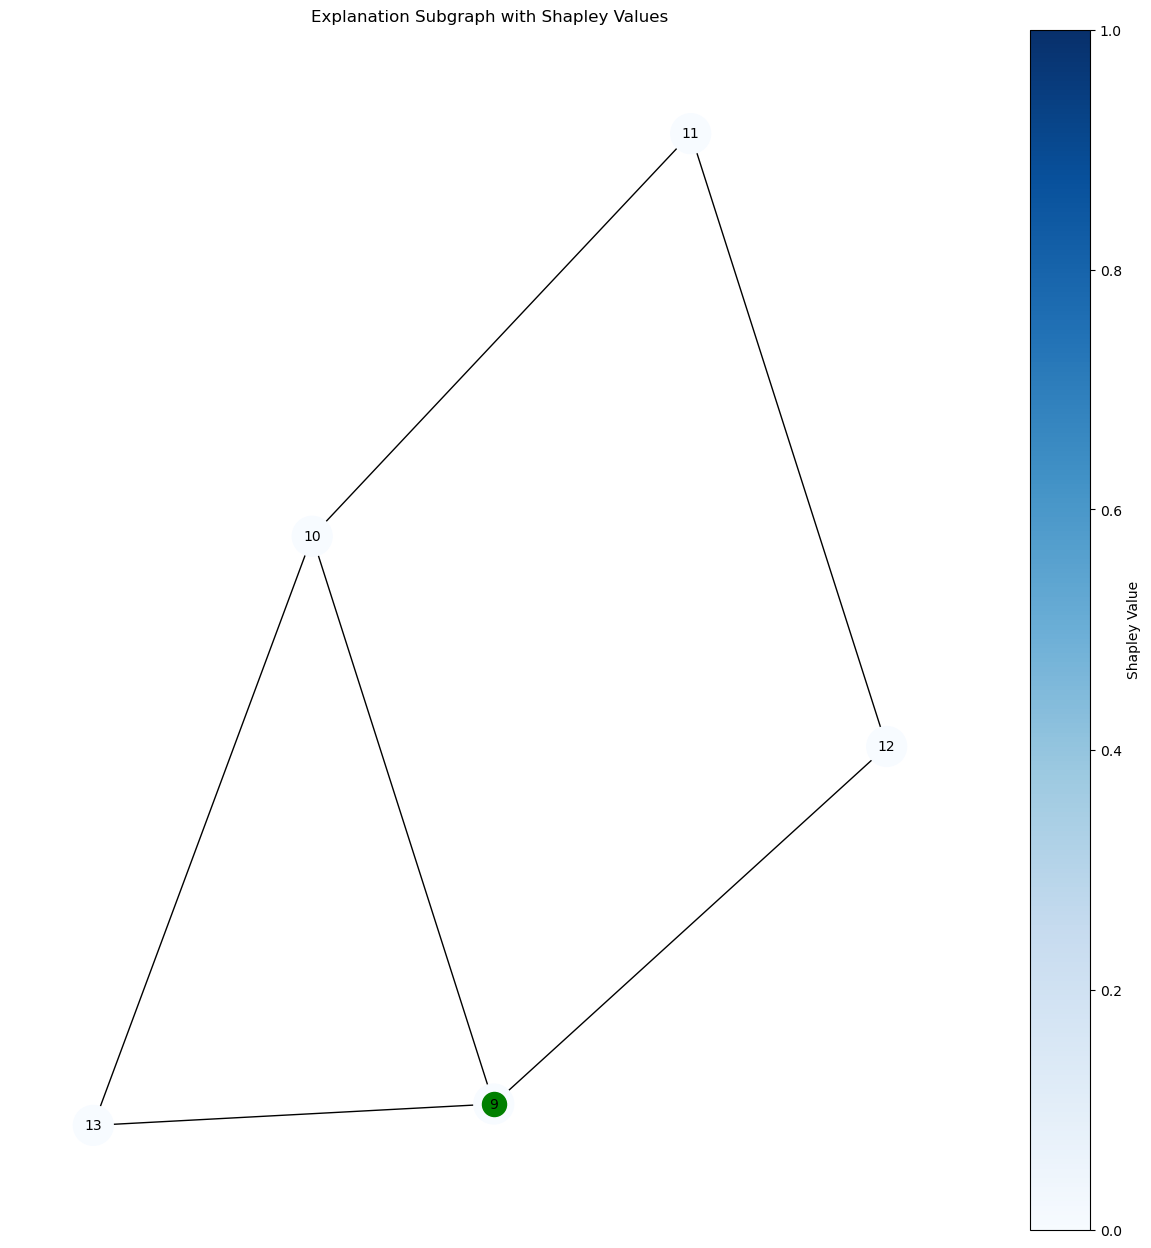

Node 9 - Shapley Value: 0.8204
Node 10 - Shapley Value: 0.8204
Node 11 - Shapley Value: 0.8204
Node 12 - Shapley Value: 0.8204
Node 13 - Shapley Value: 0.8204


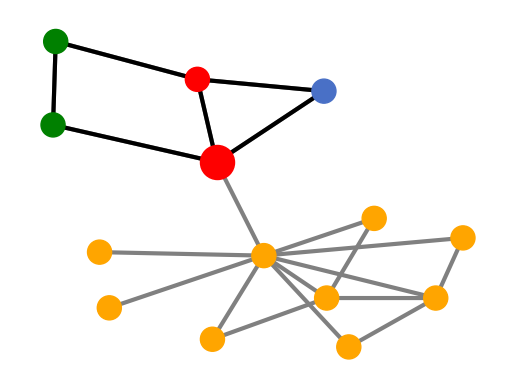

In [16]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
import torch
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `dataset` is defined elsewhere in your code
# dataset = ... (Load or define your dataset here)

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

# Visualization
max_nodes = 5
node_idx = node_indices[20]
highlight_node = 515
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

# Obtain the explanation results
_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

# Step 1: Extract Subgraph Information from explanation_results
def extract_subgraph_info(explanation_results):
    nodes = set()
    edges = set()
    detailed_info = []
    for mcts_node in explanation_results:
        coalition_nodes = mcts_node.coalition
        if coalition_nodes is not None:
            nodes.update(coalition_nodes)
            mcts_edges = mcts_node.data.edge_index.t().tolist()
            for edge in mcts_edges:
                if edge[0] in coalition_nodes and edge[1] in coalition_nodes:
                    edges.add((edge[0], edge[1]))
            detailed_info.append({
                "nodes": coalition_nodes,
                "edges": [(edge[0], edge[1]) for edge in mcts_edges if edge[0] in coalition_nodes and edge[1] in coalition_nodes],
                "score": mcts_node.info.get("W", None),
                "P": mcts_node.P,
                "N": mcts_node.N
            })
        else:
            print("Coalition not found in MCTSNode")
    return nodes, edges, detailed_info

# Extract nodes, edges, and detailed info from explanation_results
nodes, edges, detailed_info = extract_subgraph_info(explanation_results)

# Print the best subgraph information
best_subgraph = max(detailed_info, key=lambda x: x["score"])

print("\nBest Subgraph:")
print(f"  Nodes: {best_subgraph['nodes']}")
print(f"  Edges: {best_subgraph['edges']}")
print(f"  Score: {best_subgraph['score']}")
print(f"  P: {best_subgraph['P']}")
print(f"  N: {best_subgraph['N']}")

# Function to visualize 2-hop subgraph
def visualize_2hop_subgraph(data, highlight_node):
    G = nx.Graph()
    overall_edges = data.edge_index.t().tolist()
    G.add_edges_from(overall_edges)
    
    # Extract 2-hop subgraph
    two_hop_subgraph = nx.ego_graph(G, highlight_node, radius=2)
    
    pos = nx.spring_layout(two_hop_subgraph)
    plt.figure(figsize=(12, 12))
    
    # Draw 2-hop subgraph
    nx.draw(two_hop_subgraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
    nx.draw_networkx_nodes(two_hop_subgraph, pos, nodelist=[highlight_node], node_color='red')
    
    plt.title("2-hop Subgraph around Node 515")
    plt.show()

# Function to visualize explanation subgraph with Shapley values
def visualize_explanation_subgraph(best_subgraph, explanation_results, highlight_node):
    G = nx.Graph()
    G.add_nodes_from(best_subgraph['nodes'])
    G.add_edges_from(best_subgraph['edges'])

    pos = nx.spring_layout(G)
    
    # Calculate Shapley values and set node sizes and colors
    shapley_values = {node: next(mcts_node for mcts_node in explanation_results if node in mcts_node.coalition).P for node in best_subgraph['nodes']}
    node_sizes = [1000 * shapley_values[node] for node in G.nodes()]
    node_colors = [shapley_values[node] for node in G.nodes()]

    plt.figure(figsize=(12, 12))
    
    # Draw explanation subgraph
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues, font_size=10, font_color='black')
    if highlight_node in G.nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=[highlight_node], node_color='red')
    
    # Highlight node with the highest Shapley value
    max_shapley_node = max(shapley_values, key=shapley_values.get)
    nx.draw_networkx_nodes(G, pos, nodelist=[max_shapley_node], node_color='green')
    
    plt.title("Explanation Subgraph with Shapley Values")
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), label='Shapley Value')
    plt.show()

    # Print node information
    for node in G.nodes:
        print(f"Node {node} - Shapley Value: {shapley_values[node]:.4f}")

# Visualize the 2-hop subgraph
visualize_2hop_subgraph(data, highlight_node)

# Visualize the explanation subgraph with Shapley values
visualize_explanation_subgraph(best_subgraph, explanation_results, highlight_node)

# Visualization with original plotutils
plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
explainer.visualization(explanation_results,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

explain graph node 515


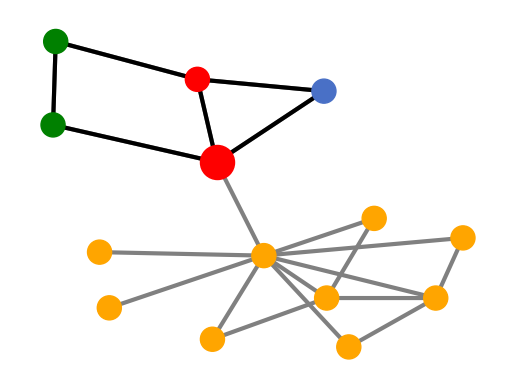

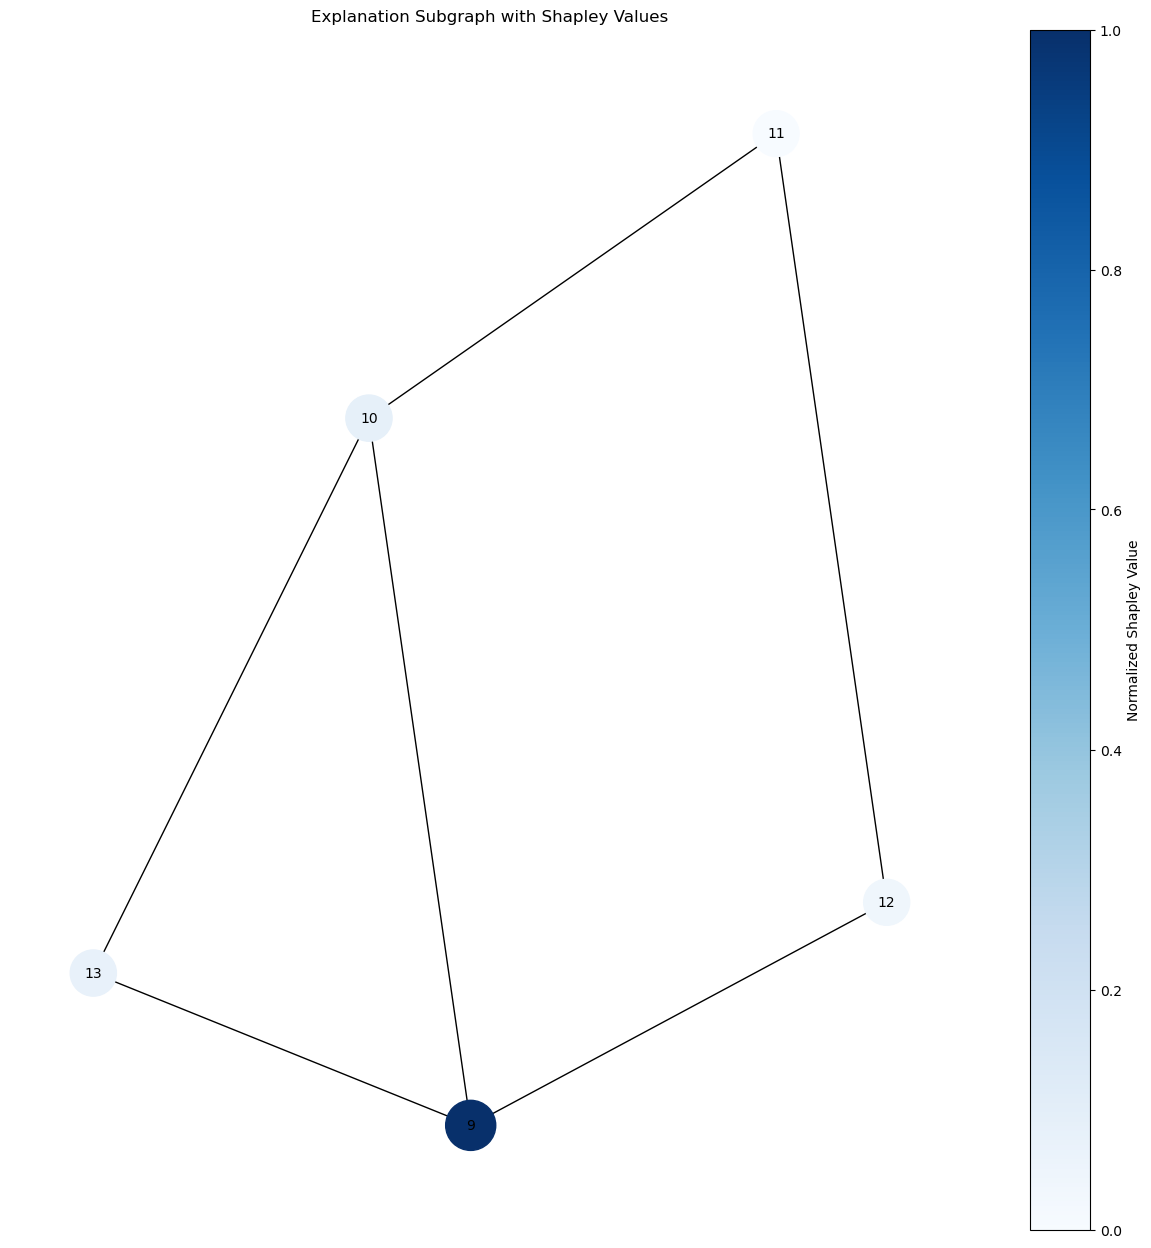

Node 9 - Shapley Value: 264.3384
Node 10 - Shapley Value: 233.9627
Node 11 - Shapley Value: 231.0784
Node 12 - Shapley Value: 232.4444
Node 13 - Shapley Value: 233.6601


In [21]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
from dig.xgraph.method import SubgraphX
from dig.xgraph.method.subgraphx import PlotUtils, find_closest_node_result
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `dataset`, `model`, and `device` are defined elsewhere in your code
# dataset = ... (Load or define your dataset here)

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

# Initialize SubgraphX explainer
explainer = SubgraphX(model, num_classes=4, device=device, explain_graph=False, reward_method='nc_mc_l_shapley')
plotutils = PlotUtils(dataset_name='ba_shapes')

# Visualization
max_nodes = 5
node_idx = node_indices[20]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

# Obtain the explanation results
_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results[prediction])

# Use plotutils for visualization
plotutils = PlotUtils(dataset_name='ba_shapes')
explainer.visualization(explanation_results, max_nodes=max_nodes, plot_utils=plotutils, y=data.y)

# Additional visualization to check Shapley values
def visualize_explanation_subgraph(explanation_results, max_nodes, plot_utils, y):
    # Extract the best subgraph
    best_result = find_closest_node_result(explanation_results, max_nodes=max_nodes)
    nodes = best_result.coalition
    edges = best_result.data.edge_index.t().tolist()

    # Create graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from([(edge[0], edge[1]) for edge in edges if edge[0] in nodes and edge[1] in nodes])

    # Extract Shapley values for each node
    shapley_values = {node: best_result.P for node in nodes}
    for mcts_node in explanation_results:
        for node in mcts_node.coalition:
            if node in shapley_values:
                shapley_values[node] += mcts_node.P
            else:
                shapley_values[node] = mcts_node.P

    # Normalize Shapley values for node sizes
    min_shapley = min(shapley_values.values())
    max_shapley = max(shapley_values.values())
    normalized_shapley = {node: (value - min_shapley) / (max_shapley - min_shapley) for node, value in shapley_values.items()}
    node_sizes = [300 + 1000 * normalized_shapley[node] for node in G.nodes()]
    node_colors = [normalized_shapley[node] for node in G.nodes()]

    # Plot
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues, font_size=10, font_color='black')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), label='Normalized Shapley Value')
    plt.title("Explanation Subgraph with Shapley Values")
    plt.show()

    # Print node information
    for node in G.nodes:
        print(f"Node {node} - Shapley Value: {shapley_values[node]:.4f}")

# Visualize the explanation subgraph with Shapley values
visualize_explanation_subgraph(explanation_results, max_nodes, plotutils, y=data.y)

explain graph node 515


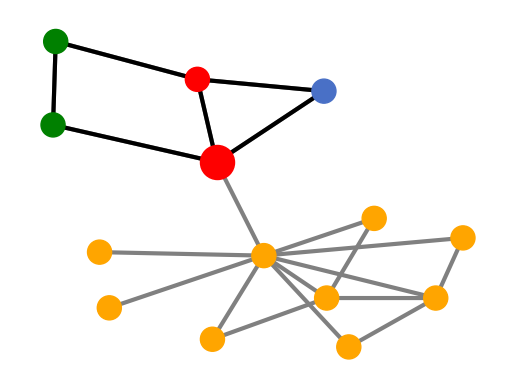

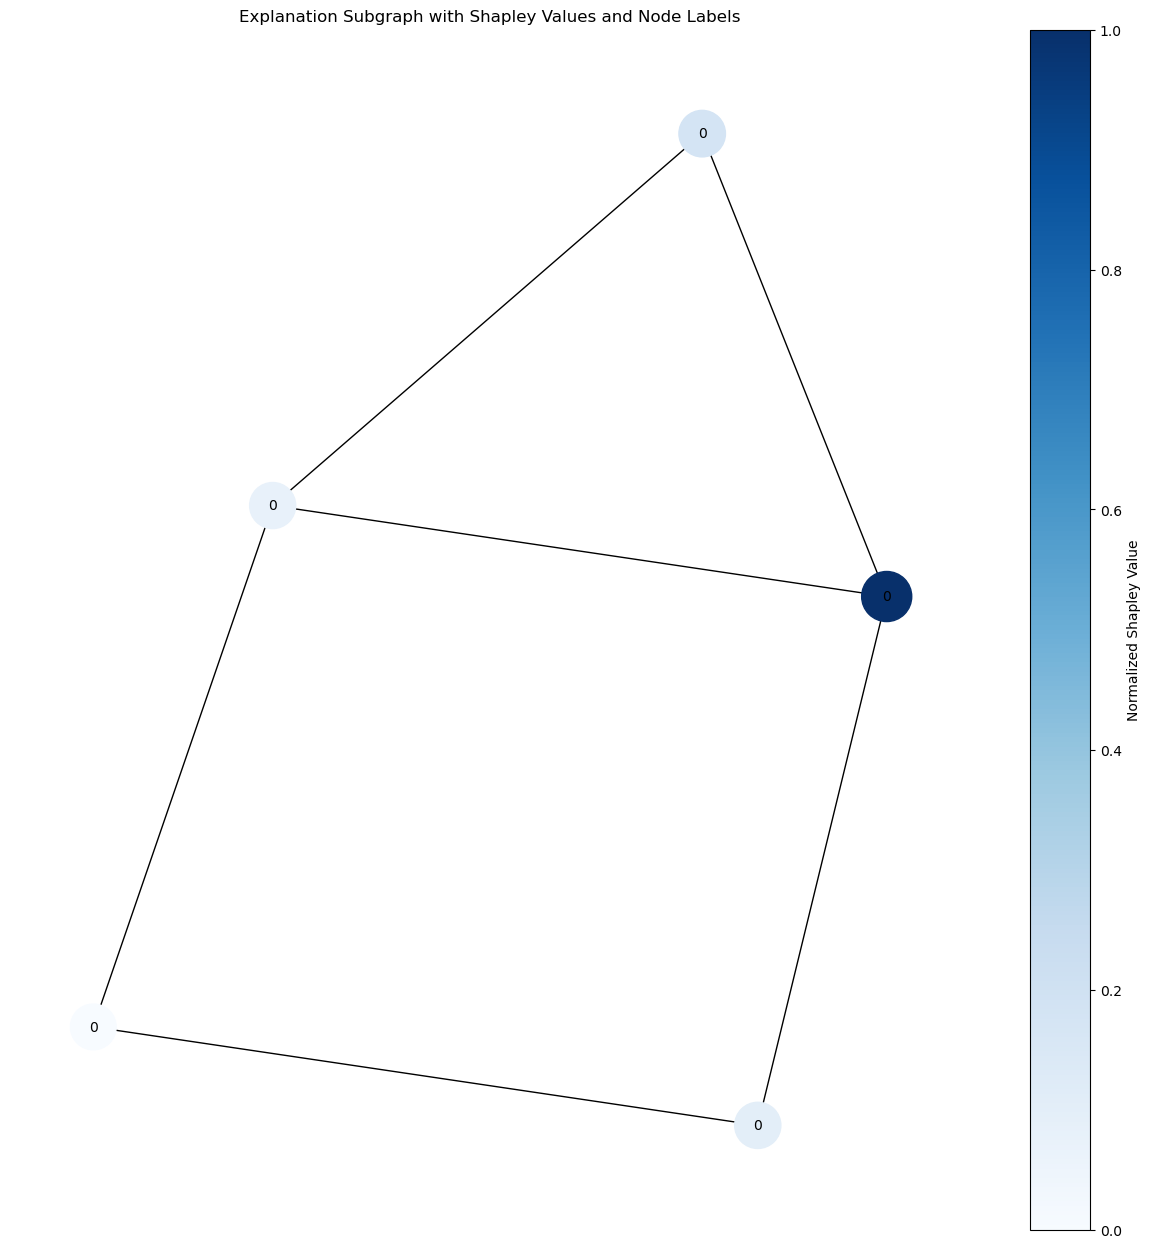

Node 9 - Shapley Value: 263.6013, Label: 0
Node 10 - Shapley Value: 231.1078, Label: 0
Node 11 - Shapley Value: 228.4533, Label: 0
Node 12 - Shapley Value: 232.0514, Label: 0
Node 13 - Shapley Value: 234.6653, Label: 0


In [22]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
from dig.xgraph.method import SubgraphX
from dig.xgraph.method.subgraphx import PlotUtils, find_closest_node_result
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `dataset`, `model`, and `device` are defined elsewhere in your code
# dataset = ... (Load or define your dataset here)

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

# Initialize SubgraphX explainer
explainer = SubgraphX(model, num_classes=4, device=device, explain_graph=False, reward_method='nc_mc_l_shapley')
plotutils = PlotUtils(dataset_name='ba_shapes')

# Visualization
max_nodes = 5
node_idx = node_indices[20]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

# Obtain the explanation results
_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results[prediction])

# Use plotutils for visualization
plotutils = PlotUtils(dataset_name='ba_shapes')
explainer.visualization(explanation_results, max_nodes=max_nodes, plot_utils=plotutils, y=data.y)

# Additional visualization to check Shapley values
def visualize_explanation_subgraph(explanation_results, max_nodes, plot_utils, y):
    # Extract the best subgraph
    best_result = find_closest_node_result(explanation_results, max_nodes=max_nodes)
    nodes = best_result.coalition
    edges = best_result.data.edge_index.t().tolist()

    # Create graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from([(edge[0], edge[1]) for edge in edges if edge[0] in nodes and edge[1] in nodes])

    # Extract Shapley values for each node
    shapley_values = {node: best_result.P for node in nodes}
    for mcts_node in explanation_results:
        for node in mcts_node.coalition:
            if node in shapley_values:
                shapley_values[node] += mcts_node.P
            else:
                shapley_values[node] = mcts_node.P

    # Normalize Shapley values for node sizes
    min_shapley = min(shapley_values.values())
    max_shapley = max(shapley_values.values())
    normalized_shapley = {node: (value - min_shapley) / (max_shapley - min_shapley) for node, value in shapley_values.items()}
    node_sizes = [300 + 1000 * normalized_shapley[node] for node in G.nodes()]
    node_colors = [normalized_shapley[node] for node in G.nodes()]

    # Extract node labels
    node_labels = {node: int(y[node].item()) for node in nodes}

    # Plot
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues, font_size=10, font_color='black')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), label='Normalized Shapley Value')
    plt.title("Explanation Subgraph with Shapley Values and Node Labels")
    plt.show()

    # Print node information
    for node in G.nodes:
        print(f"Node {node} - Shapley Value: {shapley_values[node]:.4f}, Label: {node_labels[node]}")

# Visualize the explanation subgraph with Shapley values
visualize_explanation_subgraph(explanation_results, max_nodes, plotutils, y=data.y)

In [25]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
from dig.xgraph.method import SubgraphX
from dig.xgraph.method.subgraphx import PlotUtils, find_closest_node_result
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

# Assuming `dataset`, `model`, and `device` are defined elsewhere in your code
# dataset = ... (Load or define your dataset here)

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

# Initialize SubgraphX explainer
explainer = SubgraphX(model, num_classes=4, device=device, explain_graph=False, reward_method='nc_mc_l_shapley')
plotutils = PlotUtils(dataset_name='ba_shapes')

# Visualization
max_nodes = 5
node_idx = node_indices[20]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

# Obtain the explanation results
_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results[prediction])

# Extract subgraph and corresponding node labels
def extract_subgraph_with_labels(node_idx, x, edge_index, y, num_hops):
    subgraph_x, subgraph_edge_index, subset, edge_mask, kwargs = \
        MCTS.__subgraph__(node_idx, x, edge_index, num_hops=num_hops)
    subgraph_y = y[subset].to('cpu')
    new_node_idx = torch.argwhere(subset == node_idx)[0].item()
    return subgraph_x, subgraph_edge_index, subset, subgraph_y, new_node_idx

# Extract the subgraph and labels
subgraph_x, subgraph_edge_index, subset, subgraph_y, new_node_idx = \
    extract_subgraph_with_labels(node_idx, data.x, data.edge_index, data.y, num_hops=2)

# Convert the subgraph to networkx format for visualization
vis_graph = to_networkx(Data(x=subgraph_x, edge_index=subgraph_edge_index))

# Use plotutils for visualization
plotutils.plot(vis_graph, nodelist=[], figname=None, y=subgraph_y, node_idx=new_node_idx)

# Visualize explanation subgraph with Shapley values
def visualize_explanation_subgraph(explanation_results, max_nodes, plot_utils, y):
    best_result = find_closest_node_result(explanation_results, max_nodes=max_nodes)
    nodes = best_result.coalition
    edges = best_result.data.edge_index.t().tolist()

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from([(edge[0], edge[1]) for edge in edges if edge[0] in nodes and edge[1] in nodes])

    shapley_values = {node: best_result.P for node in nodes}
    for mcts_node in explanation_results:
        for node in mcts_node.coalition:
            if node in shapley_values:
                shapley_values[node] += mcts_node.P
            else:
                shapley_values[node] = mcts_node.P

    min_shapley = min(shapley_values.values())
    max_shapley = max(shapley_values.values())
    normalized_shapley = {node: (value - min_shapley) / (max_shapley - min_shapley) for node, value in shapley_values.items()}
    node_sizes = [300 + 1000 * normalized_shapley[node] for node in G.nodes()]
    node_colors = [normalized_shapley[node] for node in G.nodes()]

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues, font_size=10, font_color='black')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), label='Normalized Shapley Value')
    plt.title("Explanation Subgraph with Shapley Values")
    plt.show()

    for node in G.nodes:
        print(f"Node {node} - Shapley Value: {shapley_values[node]:.4f}")

visualize_explanation_subgraph(explanation_results, max_nodes, plotutils, y=data.y)

explain graph node 515


NameError: name 'MCTS' is not defined

explain graph node 515
Node 515 not found in the best subgraph.

Best Subgraph:
  Nodes: [9, 10, 11, 12, 13]
  Edges: [(9, 10), (9, 12), (9, 13), (10, 9), (10, 11), (10, 13), (11, 10), (11, 12), (12, 9), (12, 11), (13, 9), (13, 10)]
  Score: 2.684941053390503
  P: 0.6712352633476257
  N: 4


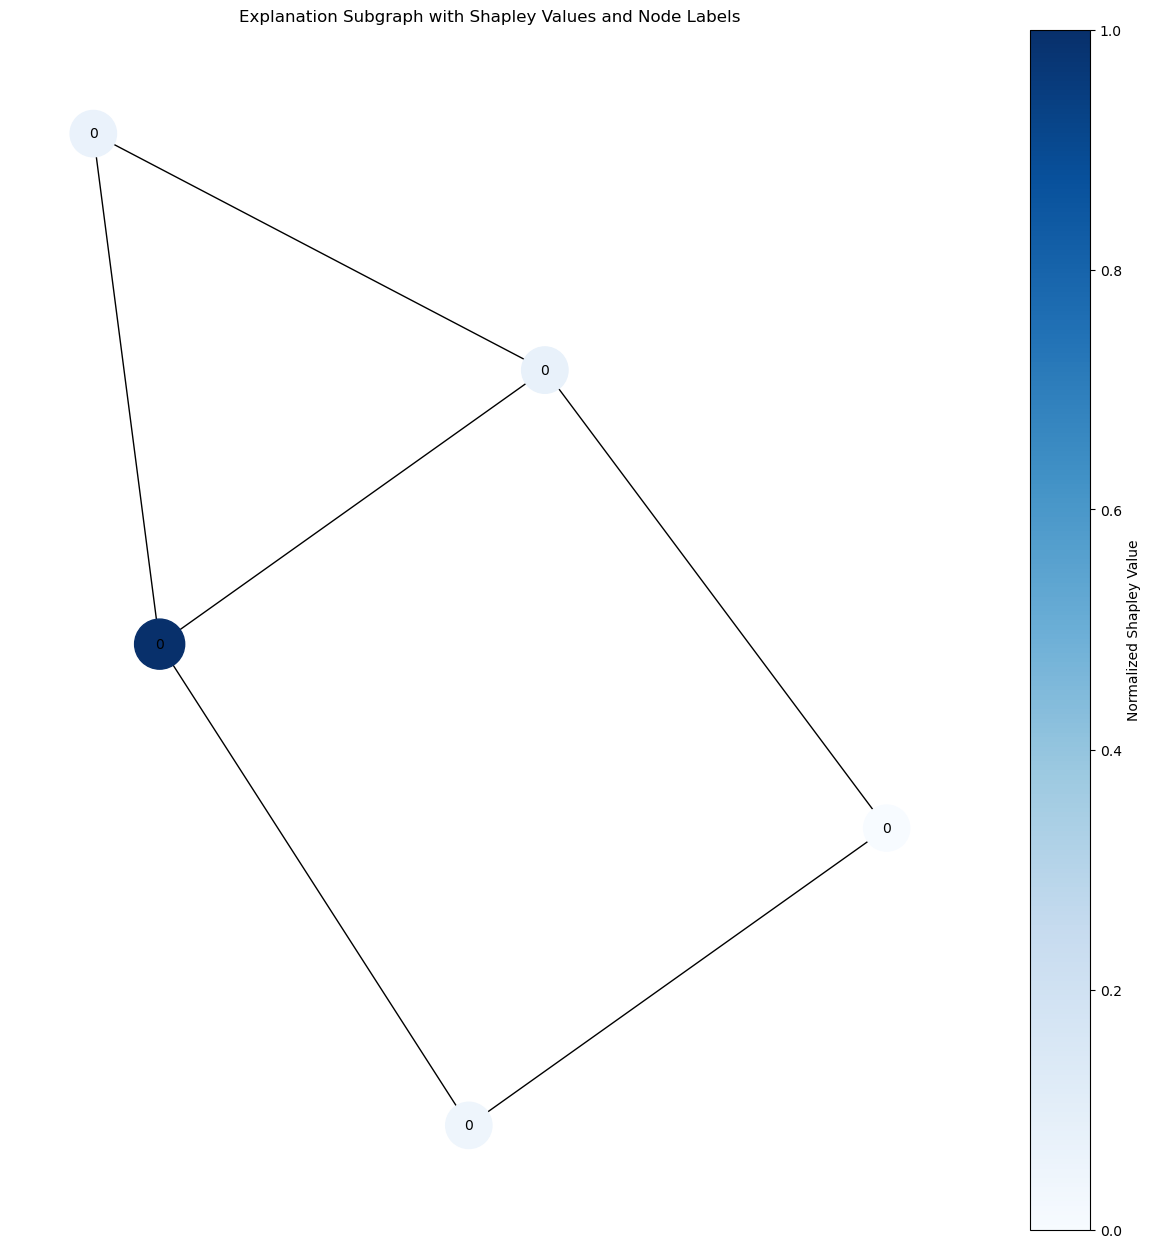

Node 9 - Shapley Value: 249.2908, Label: 0
Node 10 - Shapley Value: 219.1464, Label: 0
Node 11 - Shapley Value: 216.7018, Label: 0
Node 12 - Shapley Value: 218.1754, Label: 0
Node 13 - Shapley Value: 218.9605, Label: 0


In [24]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
from dig.xgraph.method import SubgraphX
from dig.xgraph.method.subgraphx import PlotUtils, find_closest_node_result
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `dataset`, `model`, and `device` are defined elsewhere in your code
# dataset = ... (Load or define your dataset here)

x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

# Initialize SubgraphX explainer
explainer = SubgraphX(model, num_classes=4, device=device, explain_graph=False, reward_method='nc_mc_l_shapley')
plotutils = PlotUtils(dataset_name='ba_shapes')

# Visualization
max_nodes = 5
node_idx = node_indices[20]
highlight_node = 515
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

# Obtain the explanation results
_, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results[prediction])

# Extract subgraph information from explanation_results
def extract_subgraph_info(explanation_results):
    nodes = set()
    edges = set()
    detailed_info = []
    for mcts_node in explanation_results:
        coalition_nodes = mcts_node.coalition
        if coalition_nodes is not None:
            nodes.update(coalition_nodes)
            mcts_edges = mcts_node.data.edge_index.t().tolist()
            for edge in mcts_edges:
                if edge[0] in coalition_nodes and edge[1] in coalition_nodes:
                    edges.add((edge[0], edge[1]))
            detailed_info.append({
                "nodes": coalition_nodes,
                "edges": [(edge[0], edge[1]) for edge in mcts_edges if edge[0] in coalition_nodes and edge[1] in coalition_nodes],
                "score": mcts_node.info.get("W", None),
                "P": mcts_node.P,
                "N": mcts_node.N
            })
        else:
            print("Coalition not found in MCTSNode")
    return nodes, edges, detailed_info

# Extract nodes, edges, and detailed info from explanation_results
nodes, edges, detailed_info = extract_subgraph_info(explanation_results)

# Find the subgraph with the highest score
best_subgraph = max(detailed_info, key=lambda x: x["score"])

# Check if highlight_node is in the best subgraph
if highlight_node not in best_subgraph["nodes"]:
    print(f"Node {highlight_node} not found in the best subgraph.")

# Print the best subgraph information
print("\nBest Subgraph:")
print(f"  Nodes: {best_subgraph['nodes']}")
print(f"  Edges: {best_subgraph['edges']}")
print(f"  Score: {best_subgraph['score']}")
print(f"  P: {best_subgraph['P']}")
print(f"  N: {best_subgraph['N']}")

# Additional visualization to check Shapley values
def visualize_explanation_subgraph(explanation_results, best_subgraph, original_labels, max_nodes, plot_utils):
    nodes = best_subgraph["nodes"]
    edges = best_subgraph["edges"]

    # Create graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Extract Shapley values for each node
    shapley_values = {node: 0 for node in nodes}
    for mcts_node in explanation_results:
        for node in mcts_node.coalition:
            if node in shapley_values:
                shapley_values[node] += mcts_node.P
            else:
                shapley_values[node] = mcts_node.P

    # Normalize Shapley values for node sizes
    min_shapley = min(shapley_values.values())
    max_shapley = max(shapley_values.values())
    normalized_shapley = {node: (value - min_shapley) / (max_shapley - min_shapley) for node, value in shapley_values.items()}
    node_sizes = [300 + 1000 * normalized_shapley[node] for node in G.nodes()]
    node_colors = [normalized_shapley[node] for node in G.nodes()]

    # Extract node labels
    node_labels = {node: int(original_labels[node].item()) for node in nodes}

    # Plot
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues, font_size=10, font_color='black')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), label='Normalized Shapley Value')
    plt.title("Explanation Subgraph with Shapley Values and Node Labels")
    plt.show()

    # Print node information
    for node in G.nodes:
        print(f"Node {node} - Shapley Value: {shapley_values[node]:.4f}, Label: {node_labels[node]}")

# Visualize the explanation subgraph with Shapley values
visualize_explanation_subgraph(explanation_results, best_subgraph, data.y, max_nodes, plotutils)

### The metric result

In [12]:
max_nodes = 5
for node_idx in node_indices:
    index += 1
    print(f'explain graph node {node_idx}')
    data.to(device)

    if torch.isnan(data.y[0].squeeze()):
        continue

    logits = model(data.x, data.edge_index)
    prediction = logits[node_idx].argmax(-1).item()

    _, explanation_results, related_preds = explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

    explanation_results = explanation_results[prediction]
    explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)
    result = find_closest_node_result(explanation_results, max_nodes=max_nodes)

    x_collector.collect_data(result.coalition, related_preds, label=prediction)
    if index >= 20:
        break

print(f'Fidelity: {x_collector.fidelity:.4f}\n',
      f'Infidelity: {x_collector.fidelity_inv:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

explain graph node 302
explain graph node 313
explain graph node 321
explain graph node 332
explain graph node 336
explain graph node 348
explain graph node 356
explain graph node 367
explain graph node 369
explain graph node 381
explain graph node 387
explain graph node 418
explain graph node 454
explain graph node 461
explain graph node 466
explain graph node 469
explain graph node 471
explain graph node 497
explain graph node 508
explain graph node 514
explain graph node 515
Fidelity: 0.7987
 Infidelity: 0.2386
Sparsity: 0.1818
